----------
**Bike Sharing Demand Analysis **
=====================================

***Zoe Li***

*Oct 2018*

----------

## <a id='1'>1. Identify the Problem and Data</a>

Bike sharing programs are poping up around the world and becoming increasingly popular. They provides flexible transportations for professionals and tourists to travel. People can easily rent a bike from a bike sharing station and returning it at a different place on an as-needed basis. 


![bikes](img/1.png)

Yes, this is convenient and energy-saving. However, **inaccurate estimation of bike demand** at stations leads to hidden costs for both program owners (cities, companies) and users.
- For cities or companies, maintaining bikes and the slots to return bikes can be costly. Sometimes they need to redistribute bikes between stations to ensure availability. 
- For users, will you be annoyed if there is no bikes at the nearest station and you have to find other ways to go to school/companies? What if you've rent a bike and when you arrived the destination, you find no slots there for you to return the bike?

The uncertainty of bikes at a given station has **strong business implications**, that's why it is interesting and I want to show how data science can help for **better decisions and social good**.



Now we identified the specific **regression problem** that we want to **forecast bike demand and availablility** at a bike sharing station to make the lives of companies and users easier. Next, we want to know:

- Which features do I need?
- Why these features matter?
- Where can I obtain the data?


For this, I will say weather and temperature or season should be influencing factors. (e.g.* Will you bike to school in 0°F snowy Rochester winter when you cannot open your door? What about renting a bike to travel in the 65°F lovely Autumn with colorful falling leaves?*) Other features such as windspeed, humidity, holidays could also play a role.


Fortunately, there are avaiable dataset online so I take advantage of the **dataset from Capital Bikeshare program in Washington, D.C**, which was a Kaggle competition.

More details about the data:
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy; 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist; 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds; 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals






***The structure of the demo project*** is as follows: In Section 2, I inspect data and features(weather, temperature, windspeed, etc) in the dataset. In Section 3, I train and evaluate different regression models with cross validations. The main conclusions and insights are summarized in Section 4.

-------------------

## <a id='2'>2. Feature Engineering</a>

Understainding data, preprocessing features. Takes 80% of the time.

### <a id='2.1'> 2.1 Inspect the data</a>

In [1]:
# load libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# load data
train_data = pd.read_csv("./input/train.csv")
test_data = pd.read_csv("./input/test.csv")

#### <a id='2.1.1'>2.1.1 General information</a>
After loading libraries and data, let's get a general sense of the dataset is like, for example, how many columns and rows, what the features are, etc.


In [3]:
# # data amount
rows,columns = train_data.shape
# print("• The training dataset contains " + str(columns) +" columns and " + str(rows) +" rows.\n")

# # data columns
# print("• The "+ str(columns)+ " columns represent different features: ")
# for i, feature in enumerate(train_data.columns):
#     print(str(i) +'\t' + feature)

# data info
print("\n •  "+ str(columns)+ " features, any missing values, variable datatypes:")
print(train_data.info())

#data.dtypes
#data.describe()



 •  12 features, any missing values, variable datatypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB
None


In [4]:
# first five lines of the dataset
print("\n • Here shows the first five rows of the training data:")

train_data.head()


 • Here shows the first five rows of the training data:


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
print("\n • The first five rows of the testing data for prediction and submission:")
test_data.head()


 • The first five rows of the testing data for prediction and submission:


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


Now we have a general sense of the data:

- Count is what we want to predict, that is the total amount of sharing bicycle usage.
- A variety of factors influence on the bicycle usage.(datetime, season, holiday, etc)
- casual and registered are not shown in the testdataset. drop them.

Next we want to dig a little deeper to understand each feature and their relation with the total amount of bike usage.

#### <a id='2.1.2'>2.1.2. Missing value</a>

We are lucky that the dataset is clean and there is no missing value. But in most dataset, it's not the case.

In [6]:
print(train_data.isnull().values.any())

False


**For the missing values**, we can: 
- drop them (not recommend usually);
- fill them with summary statistics (e.g. mean);
- fill them with KNN or other machine learning predictions.

For messy dataset, we can do some cleaning depends on the specific condition (e.g. string uppercase -> lowercase by regular expressions )

#### <a id='2.1.3'>2.1.3.Variables</a>
Let's first take a look at the feature we want to predict: **count**.

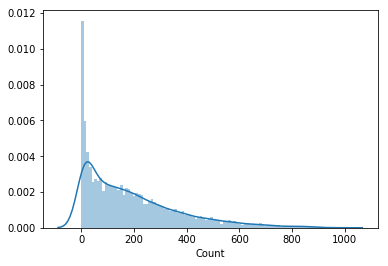

In [7]:
# count distribution
#data['count'].hist(bins=100,range=(0,1000))
sns.distplot(train_data['count'], bins=100, norm_hist=True, axlabel='Count');

We can see the amount of sharing bikes usage is **highly skewed**. 
I transformed it to a more guassian like distribution by taking a logrithm for better regression performance.

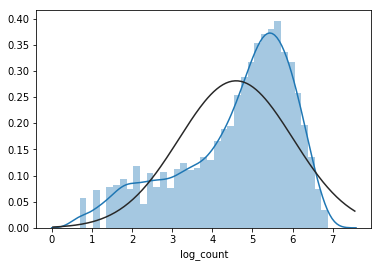

In [8]:
from scipy.stats import norm
train_data['log_count'] = np.log(train_data['count'] + 1)
sns.distplot(train_data['log_count'],fit=norm);

Now let's look at the Categorical Features: **datetime, season, holiday, weather and workingday**.

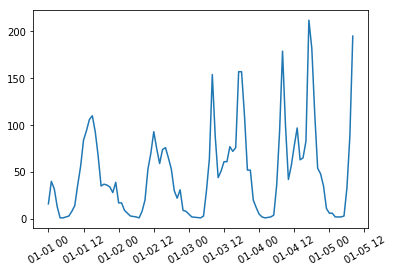

In [71]:
#sns.scatterplot(x='datetime', y='log_count', data=train_data)
plt.plot(train_data['datetime'].head(100), train_data['count'].head(100))
locs, labels = plt.xticks()
data_dt = plt.setp(labels, rotation=30)

We see ***seasonality*** in the count vs. datetime curve above. Datetime is an important feature to keep.

**datetime**: we transform it to year, month, dayofweek and hour.

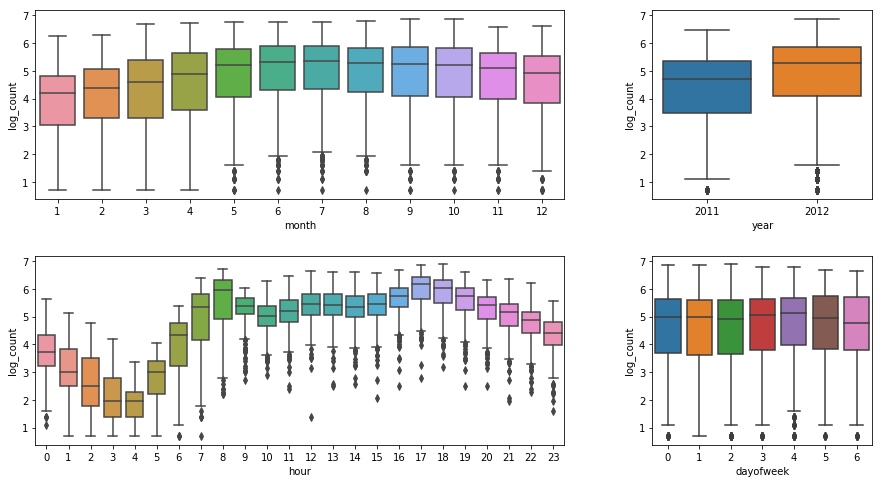

In [10]:
# datetime split
#data_dt = train_data[['datetime','log_count']].copy()
train_data['datetime']= pd.to_datetime(train_data.datetime)
train_data['year'] = train_data.datetime.dt.year
train_data['month'] = train_data.datetime.dt.month
train_data['dayofweek'] = train_data.datetime.dt.dayofweek
train_data['hour'] = train_data.datetime.dt.hour


time_features = ['month', 'year', 'hour','dayofweek']
plt.figure(figsize=(15, 8))
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
for i, feature in enumerate(time_features):
    if (i%2 == 0): plt.subplot(grid[i//2, :2])
    else: plt.subplot(grid[i//2, 2])
    sns.boxplot(feature, 'log_count', data=train_data)

All the features listed above show influence on the variable of interest. Hence, we should keep them in our regression analysis. 

Next, let's explore other categorical features: 

**season; holiday; weather; and workingday**.

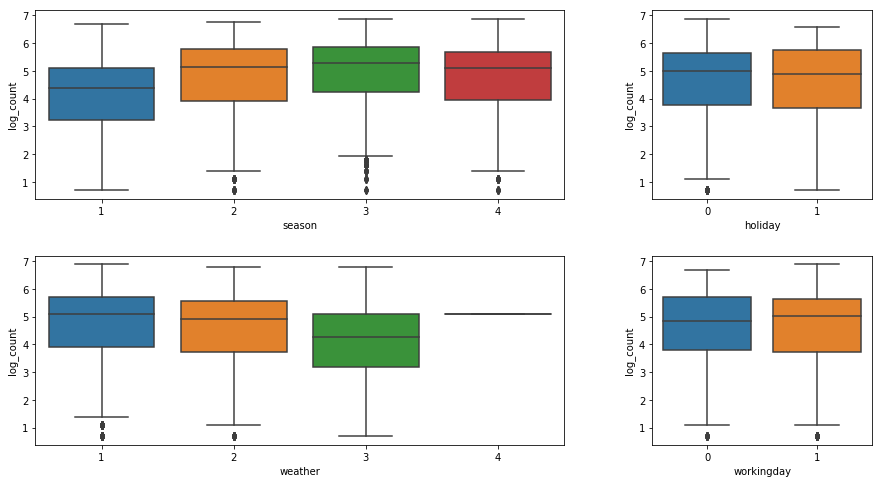

In [11]:
cat_features = ['season', 'holiday', 'weather', 'workingday']

grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

plt.figure(figsize=(15, 8))
for i, feature in enumerate(cat_features):
    if (i%2 == 0): plt.subplot(grid[i//2, :2])
    else: plt.subplot(grid[i//2, 2])
    sns.boxplot(feature, 'log_count', data=train_data)

From the figures, season and weather have a noticable influence on count.

We further noticed the data for weather = 4 seems very limited. Let's take a look.

In [12]:
# check the trainingdata
print(train_data[train_data['weather'] == 4]['count'])
train_data[train_data['weather'] == 4]

5631    164
Name: count, dtype: int64


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,log_count,year,month,dayofweek,hour
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,5.105945,2012,1,0,18


There is only one sample in training data that have severe weather (weather = 4).

In [13]:
## check the testdata if there is weather = 4.
test_data[test_data['weather'] == 4]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
154,2011-01-26 16:00:00,1,0,1,4,9.02,9.85,93,22.0028
3248,2012-01-21 01:00:00,1,0,0,4,5.74,6.82,86,12.9980


There is only one severe weather sample in training data, and two cases in testing dataset. So weather = 4 is a rare event. For this, I decide to assign the severe weather count value of the training set directly to the two cases in testing set. 

After above analysis, there are still some mysteries:

- Common sense tells me workingdays are opposite to holidays and directly related to weekdays (Monday to Friday).
- Seasons are directly related to month.

Now let's take a look at their relations.

Categorical Features: (workingday, holiday, weekday) and (season, month)

**(workingday$\sim$ holiday $\sim$ weekday)**

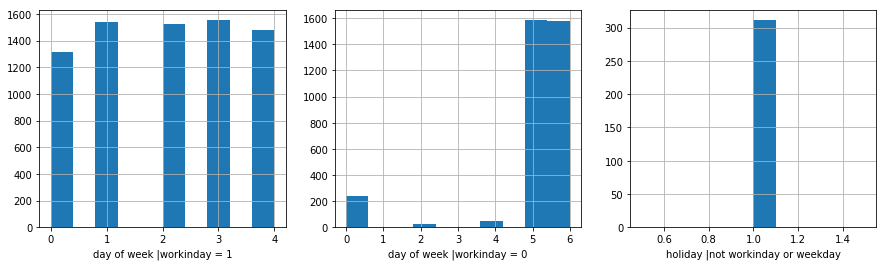

In [14]:
# relation between workingday and weekday
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
train_data[train_data['workingday'] == 1]['dayofweek'].hist()
plt.xlabel('day of week |workinday = 1')

plt.subplot(1, 3, 2)
train_data[train_data['workingday'] == 0]['dayofweek'].hist()
plt.xlabel('day of week |workinday = 0')


plt.subplot(1, 3, 3)
# if a day is not workingday or weekends, it is holiday?
train_data[(train_data['workingday'] == 0) & (train_data['dayofweek'] < 5)]['holiday'].hist()
plt.xlabel('holiday |not workinday or weekday');

If a day is a workingday, it is a weekday. If a day is not workingday, it maybe weekends or holidays.

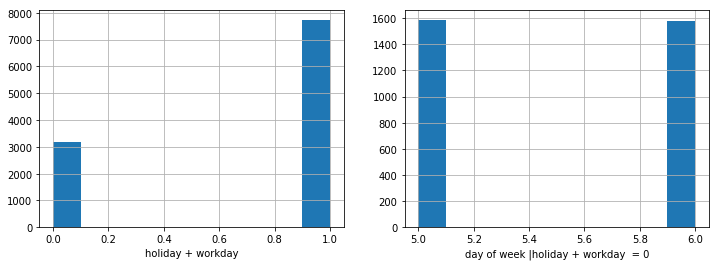

In [15]:
# relation between holiday and workingday
train_data['holidayWorkday'] = train_data['holiday'] + train_data['workingday']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
train_data['holidayWorkday'].hist()
plt.xlabel('holiday + workday')

plt.subplot(1, 2, 2)
train_data[train_data['holidayWorkday'] == 0]['dayofweek'].hist()
plt.xlabel('day of week |holiday + workday  = 0');

- There are many days that is neither holiday or workingday. They are weekends: saturday(5) and sunday(6).
- From above analysis, workingday is derivable from holidays and dayofweek. So I decide to drop workingday.

**(season $\sim$ month)**.

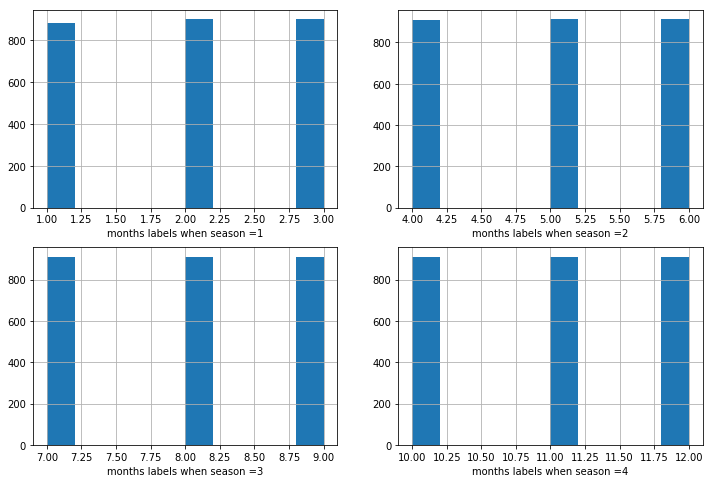

In [49]:
# relation between season and month
plt.figure(figsize=(12, 8))

for i in range(1,5):
    plt.subplot(2, 2, i)
    train_data[train_data['season'] == i]['month'].hist()
    plt.xlabel('months labels' + ' when season =' +str(i))
    


 Month category is more detailed than season category. I decide to drop season. Replicated feature could lead to overfitting.

After exploring categorical features, let's take a look at the numerical features.

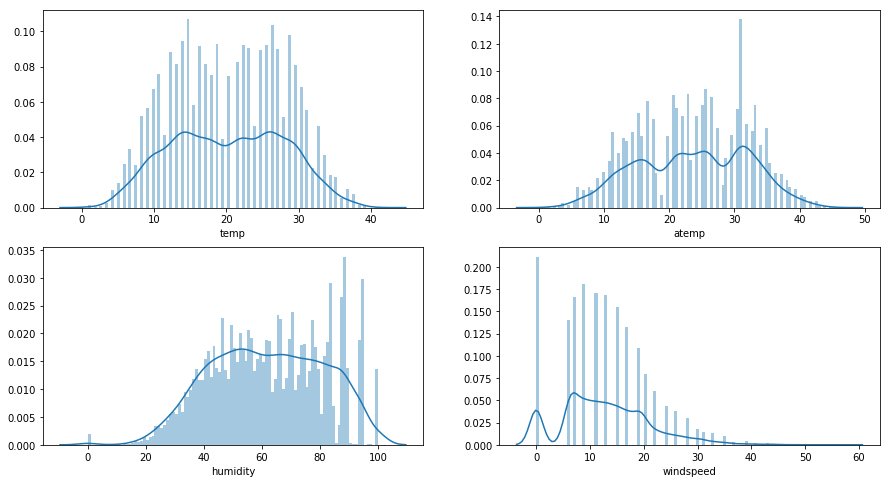

In [50]:
num_features = ['temp', 'atemp', 'humidity', 'windspeed']

plt.figure(figsize=(15, 8))
for i, feature in enumerate(num_features):
    plt.subplot(2, len(num_features)//2, i+1)
    sns.distplot(train_data[feature], bins=100, norm_hist=True, axlabel=feature)

How these numerical feature influence on count.

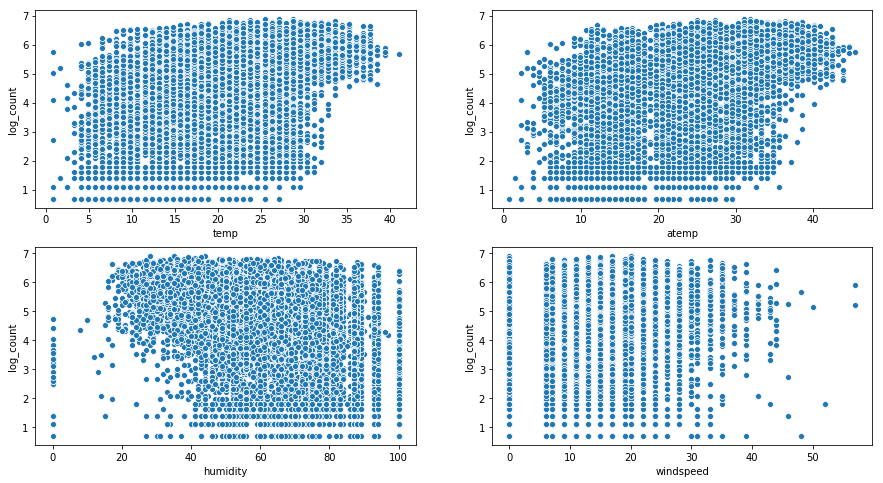

In [51]:
plt.figure(figsize=(15, 8))
for i, feature in enumerate(num_features):
    plt.subplot(2, len(num_features)//2, i+1)
    #plt.scatter(feature, 'count', data = train_data)
    sns.scatterplot(x=feature, y='log_count', data=train_data)

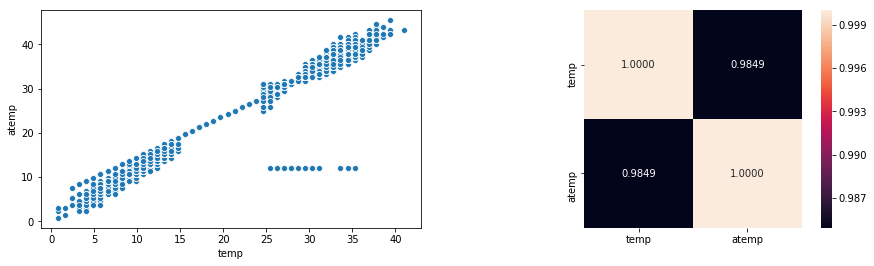

In [52]:
# relation between temp and atemp
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
sns.scatterplot(x='temp', y='atemp', data=train_data)

plt.subplot(1,2,2)
sns.heatmap(train_data[['temp', 'atemp']].corr(), fmt='.4f', annot=True, square=True)

- From the atemp vs. temp subplot, we can see a plateau, which means something may be wrong in the data.
- temp and atemp are highly positively correlated.

In [53]:
# Anything wrong in atemp or temp?
atemp_temp_plateau = (train_data['temp']/train_data['atemp']).sort_values(ascending=False).head(40)
print(atemp_temp_plateau)

9006    2.909241
9005    2.909241
9004    2.841584
9007    2.841584
9009    2.773927
9008    2.773927
9003    2.773927
9002    2.570957
9001    2.503300
9010    2.503300
9011    2.435644
9000    2.367987
8991    2.300330
8999    2.300330
9012    2.300330
8992    2.232673
8993    2.232673
9013    2.232673
9014    2.165017
8998    2.165017
8996    2.165017
8995    2.165017
8994    2.165017
8997    2.097360
6141    1.802198
6142    1.802198
6150    1.514512
6135    1.514512
6139    1.441758
184     1.353135
186     1.353135
187     1.353135
6140    1.353135
6137    1.298153
194     1.298153
5485    1.262926
5487    1.262926
5482    1.217822
5484    1.082508
5483    1.082508
dtype: float64


Text(0.5,1,'temp')

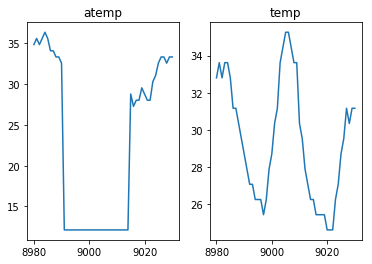

In [54]:
plt.subplot(121)
train_data.loc[8980:9030, 'atemp'].plot()
plt.title('atemp')
plt.subplot(122)
train_data.loc[8980:9030, 'temp'].plot()
plt.title('temp')

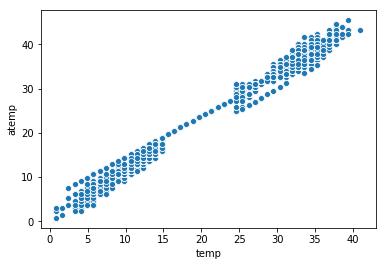

In [55]:
# test if it is atemp that have wrong data
sel = (train_data['temp']/train_data['atemp']).sort_values(ascending=False)[:24].index
test_temp_atemp= train_data[['temp', 'atemp']].copy()
test_temp_atemp.loc[sel, 'atemp'] = test_temp_atemp.loc[sel, 'temp']
sns.scatterplot(x='temp', y='atemp', data=test_temp_atemp)

The plateau in previous scatter plot comes from the atemp feature. Because atemp and temp are highly positively correlated, I decided to drop atemp feature.

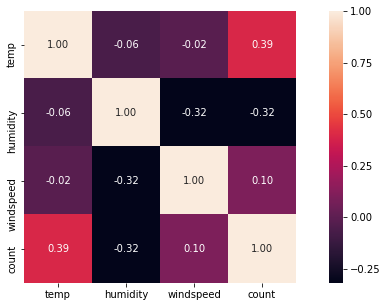

In [56]:
plt.subplots(figsize=(12, 5))
sns.heatmap(train_data[['temp', 'humidity', 'windspeed', 'count']].corr(), fmt='.2f', annot=True, square=True)

Temperature-Count: positive correlation; Humidity-Count: negatively correlation; Windspeed-Count: not so strong positive correlation.

### <a id='2.2'>2.2. Data preprocessing</a>
Why we need preprocessing?

- Data transform (numerical: standardization; categorical: dummy variables or one hot encoding)
- Feature augmentation (e.g. datetime -> year, month, dayofweek, hour)
- Feature selection (e.g. drop season, drop severe weather condition that weather = 4)
- Dimension Reduction

In [57]:
#print(train_data.isnull().values.any())
train_data = train_data[train_data['weather']!=4]

In previous exploration, the count variable have been transformed to a logrithm scale data that is less skewed and more guassian.

In [58]:
from patsy import dmatrices

def reformat(data):
    dc = data.copy(deep=True)
    y,X = dmatrices('log_count~C(holiday)+C(weather)+C(year)+C(month)+C(hour)+C(dayofweek)+temp+humidity+windspeed', dc, return_type='dataframe')
    return y,X


#train_data.drop(['datetime', 'atemp', 'holidayWorkday'], axis=1)
#train_data.columns
#train_data.head()

-------------------

## <a id='3'>3. Train and Test with Models</a>


### <a id='3.1'>3.1. Split Data</a>

In [59]:
#train_data = train_data[train_data['weather']!=4]

y, X = reformat(train_data)


# from sklearn.model_selection import train_test_split, cross_val_score
# xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)

### <a id='3.2'>3.2. Regression Models</a>

In [60]:
# The criteria RMSLE is np.sqrt(((ytrain - ypred)**2).sum() / len(ytrain)). Here y = log(count) + 1; Given in Kaggle.
# Root Mean Squared Logarithmic Error (RMSLE). 

# cross-validation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

def rmse_cv(model):
    kf = KFold(n_splits=3, shuffle=True, random_state=0)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return(rmse.mean())


#### <a id='3.2.1'>3.2.1. Linear Regression with L1/L2 Norm</a>

#### <a id='3.2.2'>3.2.2. KNeighborsRegressor</a>

#### <a id='3.2.3'>3.2.3. DecisionTreeRegressor</a>

#### <a id='3.2.4'>3.2.4. Ensemble Method (RandomForest,GradientBoostingRegressor)</a>

#### <a id='3.2.5'>3.2.5. Neural Network</a>

In [61]:
# 3.2.1 Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

LinearR = LinearRegression()

# 3.2.2 KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

# 3.2.3 DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# 3.2.4 Ensemble Method
from sklearn.ensemble import RandomForestRegressor
randomF = RandomForestRegressor()



from sklearn.ensemble import GradientBoostingRegressor
GBoost = GradientBoostingRegressor()
#GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
#                                   min_samples_leaf=15, min_samples_split=10, loss='huber')



# 3.2.5 Neural Network
from sklearn.neural_network import MLPRegressor
MLP = MLPRegressor(hidden_layer_sizes=(100, ), learning_rate_init=0.001, early_stopping=False)
#print(rmse_cv(MLP))

### Training 

In [62]:

model_list = [LinearR,Lasso(), Ridge(), 
              KNeighborsRegressor(),DecisionTreeRegressor(),
              randomF, GBoost, MLP]

#AdaBoostRegressor(),BaggingRegressor(),model_xgb


rmsle = []
for model in model_list:
    rmsle.append(rmse_cv(model))
    
d={'Model':model_list,'RMSLE':rmsle}   
rmsle_frame=pd.DataFrame(d)
rmsle_frame

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array wa

,Model,RMSLE
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.582652
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",1.247011
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.582837
3,"KNeighborsRegressor(algorithm='auto', leaf_siz...",1.226282
4,"DecisionTreeRegressor(criterion='mse', max_dep...",0.644249
5,"RandomForestRegressor(bootstrap=True, criterio...",0.490312
6,"GradientBoostingRegressor(alpha=0.9, criterion...",0.563502
7,"MLPRegressor(activation='relu', alpha=0.0001, ...",0.453262


LinearRegression: some **insight** about how each factors influencing the bike sharing demand.

In [63]:
model = LinearRegression()
model.fit(X,y)

pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))

,0,1
0,Intercept,[-9.548617489313321e-15]
1,C(holiday)[T.1],[0.029195357289270855]
2,C(weather)[T.2],[-0.05497896788285877]
3,C(weather)[T.3],[-0.5377814093620463]
4,C(year)[T.2012],[0.481161609228673]
5,C(month)[T.2],[0.16804626249022908]
6,C(month)[T.3],[0.25408678221404335]
7,C(month)[T.4],[0.4622133226646248]
8,C(month)[T.5],[0.6803105989550916]
9,C(month)[T.6],[0.6197996488541079]


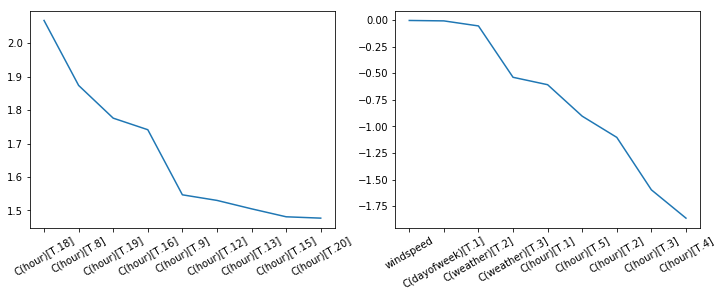

In [77]:
LinearCoeff = pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))
LinearCoeff.columns = ['features', 'coeffs']
Increase_demand = LinearCoeff.sort_values(by=['coeffs'],ascending=False).head(10)
Decrease_demand = LinearCoeff.sort_values(by=['coeffs'], ascending=False).tail(10)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(Increase_demand['features'].iloc[1:48],Increase_demand['coeffs'].iloc[1:48])
locs, labels = plt.xticks()
increase = plt.setp(labels, rotation=30)

plt.subplot(1, 2, 2)
plt.plot(Decrease_demand['features'].iloc[1:48],Decrease_demand['coeffs'].iloc[1:48])
locs, labels = plt.xticks()
decrease = plt.setp(labels, rotation=30)

**Insight**: which time in a day is the most important factor influencing bike demand.

- 18:00-19:00 and 8:00-9:00 are the times when people are leaving and going to work/school and people tend to use more bikes.
- 1:00-5:00 people are sleeping and the sharing bike demand is low.
- We notice not so good weather can directly influence bike demand. (e.g. weather2 are Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist; weather 3 are Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds;)
- From the result, people tend to rent less bikes on Tuesdays, which is interesting :)

An example of GridSearch to find better **Hyperparameters**:

In [34]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(DecisionTreeRegressor(), scoring="neg_mean_squared_error", cv=3, verbose=1,
                  param_grid={"max_depth": [2, 5, 10, 20, 50, 100, None], 
                              "min_samples_split":[2, 5, 10, 20, 50, 100]}, )
gs.fit(X, y)
print(gs.best_params_)

rmse_cv(gs.best_estimator_)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
{'max_depth': 20, 'min_samples_split': 50}


[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:    5.6s finished


0.5797195586108727

### Prediction

In [31]:
def reformat_test(data):
    dc = data.copy(deep=True)
    dc['datetime'] = pd.to_datetime(dc.datetime)
    dc['year'] = dc.datetime.dt.year
    dc['month'] = dc.datetime.dt.month
    dc['dayofweek'] = dc.datetime.dt.dayofweek
    dc['hour'] = dc.datetime.dt.hour
    dc['weather_2']= dc['weather']
    dc.loc[dc['weather_2'] == 4, 'weather'] = 1
    
    ytest,Xtest = dmatrices('atemp~C(holiday)+C(weather)+C(year)+C(month)+C(hour)+C(dayofweek)+temp+humidity+windspeed', dc, return_type='dataframe')
    return Xtest

In [32]:
# get the indexes when weather=4 in the testset
#test_data = pd.read_csv("./input/test.csv")
testset_severe_weather = list(test_data[test_data['weather']==4].index)

test_reform = reformat_test(test_data)
#test_reform.head()

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a15cf96a0>]],
      dtype=object)

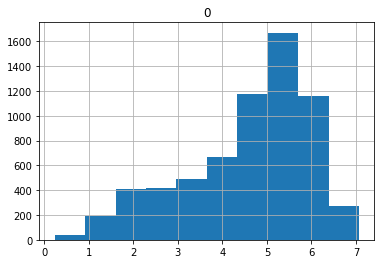

In [33]:
model = MLP
model.fit(X, y)
res_logcount= model.predict(test_reform)
res_count = ((np.exp(res_logcount)).astype(int) - 1 )

# Take a look of the predicted distribution
pd.DataFrame(result).hist()

In [34]:
# Write to submission
df = pd.DataFrame({"datetime": test_data['datetime'],"count": res_count})
df.to_csv('submission.csv',header=True, index=False)
#print(res)

-------------------

## <a id='4'>4. Summary</a> 

This project applied a basic data mining framework on a specific regression problem for predicting bike demand and availablility at a bike sharing station, which includes first identifying problems and data, exploring and preprocessing data, and training, testing and comparing machine learning models for better predictions.

From the project, we can obtain **direct insights** about the bike sharing demand from linear regression :
- 18:00-19:00 and 8:00-9:00 are the times when people are leaving and going to work/school and people tend to use more bikes.
- 1:00-5:00 people are sleeping and the sharing bike demand is low.
- We notice not so good weather can directly lower bike demand. 
- People tend to rent less bikes on Tuesdays.

More advanced machine linear models such as neural network (e.g. multilayer perceptron) can give out **more accurate predictions**. (RMSLE is 0.45 using default MLP and is 0.65 using linear regression)

For competitions, one can search better hyperparameters in advanced models to improve the model performance. But we should also be careful about overfittings.


This project helps **decision making for companies and social good for communities**. It helps cities or companies to improve their policies on maintaining bikes and lower the renting risks for ridders. 


For future extensions, the dataset holds rich potential not only for further advanced regression models training but also using feature engineering on:

- time series analysis, for example, how historical renting changes current renting preference.
- stronger feature augmentations: will friday 9:00 stronger than just fridays and 9:00s?
- understanding and dealing with outliers.
- extend other features such as local festivals date, backing to school dates, etc.
